# V-CNN code support for paper:
R. Dogaru and Ioana Dogaru, "V-CNN: A versatile light CNN structure for image recognition on resources-constrained platforms"
Copyright Radu and Ioana Dogaru, contact: radu.dogaru@upb.ro

#CELL 0 - run only when emnist or svhn datasest are needed



In [ ]:
!pip install extra-keras-datasets
from extra_keras_datasets import emnist, svhn

# CELL 1  -Loading datsets, scaling and defining input/output shapes  
may be replaced with other procedures to access data, e.g. using data generators

In [1]:
import tensorflow as tf
import numpy as np
import keras

dataset='cifar10' # mnist or f-mnist or cifar10
reduced=0  #  a positive value represents a reduced number of training samples (when memory allocation problems occur)
dformat='channels_last'

from keras.datasets import mnist, cifar10, cifar100, fashion_mnist


if dataset=='mnist':
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
elif  dataset=='cifar10':
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
elif  dataset=='cifar100':
    (x_train, y_train), (x_test, y_test) = cifar100.load_data()
elif dataset=='f-mnist':
    (x_train, y_train), (x_test, y_test) =  fashion_mnist.load_data()
elif dataset=='emnist':
    (x_train, y_train), (x_test, y_test) =  emnist.load_data()
elif dataset=='svhn':
    (x_train, y_train), (x_test, y_test) =  svhn.load_data()

if (np.ndim(x_train)==3):   # E.g.  MNIST or F-MNIST
    x_train=np.reshape(x_train, [np.shape(x_train)[0],np.shape(x_train)[1],np.shape(x_train)[2], 1])
    x_test=np.reshape(x_test, [np.shape(x_test)[0],np.shape(x_test)[1],np.shape(x_test)[2], 1] )
# place a  1 in the end to keep it compatible with kernel in conv2d
# scaling in ([0,1])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /=255
inp_chan=np.shape(x_train)[3]
print('Number of input channels in image:', inp_chan)
num_classes=int(np.max(y_train)+1)
num_inputs = np.shape(x_test)[1]
input_shape=np.shape(x_train)[1:4]


# if reduced >0
if reduced>0:
    Ntr1=reduced
    x_train=x_train[0:Ntr1,:,:,:]
    y_train=y_train[0:Ntr1]
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print('Training samples: ',np.shape(x_train)[0]); print('Esantioane test: ',np.shape(x_test)[0]);
print('Input data shape : ', np.shape(x_train)[1], 'x', np.shape(x_train)[2] )
print('Number of classes: ',num_classes)

170498071/170498071 [==============================] - 13s 0us/step
Number of input channels in image: 3
Training samples:  50000
Esantioane test:  10000
Input data shape :  32 x 32
Number of classes:  10


# CELL 2-   V-CNN model (defining function)

In [2]:
# V-CNN Versatile CNN model -
# includes L-CNN, NL-CNN and XNL-CNN as particular cases.
# The basic unit is the "macro-layer" as in the XNL-CNN but here one can independently choose the
# filter size (fil) and
# nonlinearity nl (0 means "linear" convolution)
# It allows any number of additional dense layers e.g. hid=[] (no hidden dense) or hid =[100, 100] (two additional).
# Copyright Radu and Ioana DOGARU - correspondence: radu.dogaru@upb.ro
# Last update June 21, 2023
#-------------------------------------------------------------------------------------------------

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, SeparableConv2D  # straturi convolutionale si max-pooling
from tensorflow.keras.optimizers import RMSprop, SGD, Adadelta, Adam, Nadam

#--------------------------  ------------------------------
def create_v_cnn_model(input_shape, num_classes, flat=1, fil=[100,100,100,100], nl=[1,1,0,0], hid=[]):
    # Note the number of elements in fil list (macrolayers) should be the same in nl list
    # hid can be [] while if the are elements, additional dense layers are added in the output classifier

    csize=3; stri=2; psiz=4; pad='same';
    drop1=0.6  # Best value for CIFAR-100 after tuning in range 0.25 - 0.75 !

    nfilmax=np.shape(np.array(fil))[0]
    model = Sequential()
    # First macrolayer - connected to input  ----------------
    layer=0
    if nl[layer]>0:
        model.add(Conv2D(fil[layer], padding=pad, kernel_size=(csize, csize), input_shape=input_shape ) )
        model.add(Activation('relu'))
        for nonlin in range(1,nl[0]):
            model.add(Conv2D(fil[layer], padding=pad, kernel_size=(csize, csize)) )
            model.add(Activation('relu'))

        model.add(Conv2D(fil[0], padding=pad, kernel_size=(csize, csize) ) )
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(psiz, psiz),strides=(stri,stri),padding=pad))
        model.add(Dropout(drop1))

    else:
        model.add(Conv2D(fil[0], padding=pad, kernel_size=(csize, csize), input_shape=input_shape ) )
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(psiz, psiz),strides=(stri,stri),padding=pad))
        model.add(Dropout(drop1))
    # The remaining  macro-layers

    for layer in range(1,nfilmax):
        #------------------ nonlin layers -----------------
        for nonlin in range(nl[layer]):
            model.add(Conv2D(fil[layer], padding=pad, kernel_size=(csize, csize)) )
            model.add(Activation('relu'))

        #----------------- default macrolayer output

        model.add(Conv2D(fil[layer], padding=pad, kernel_size=(csize, csize)) )
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(psiz, psiz),strides=(stri,stri),padding=pad))
        model.add(Dropout(drop1))

    # Exit classifier
    # INPUT TO DENSE LAYER (FLATTEN - more data can overfit / GLOBAL - less data - may be a good choice )
    if flat==1:
        model.add(Flatten())  # alternanta cu GlobalAv ..
    elif flat==0:
        model.add(GlobalAveragePooling2D()) # pare sa fie mai Ok la cifar
    nhid=np.shape(np.array(hid))[0]
    if nhid>0:
        for lay in range(nhid):
            model.add(Dense(hid[lay], activation='relu'))
            #model.add(Dropout(drop1))
    model.add(Dense(num_classes, activation='softmax'))

# END OF MODEL DESCRIPTION
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
    )
    return model



# CELL 3  - instantiate V-CNN model with its hyper-parameters  

In [17]:
#with strategy.scope():   #  For TPU support (initialization of strategy needed)
model=create_v_cnn_model(input_shape, num_classes, flat=0, fil=[100, 150,200, 200], nl=[2,1,1,0], hid=[100])
model.summary()
# The above is a maximal (fat) model tuned for cifar100
# Parameters have to adjusted (e.g. by division with a factor )
# to cope with data and produce lighter models.
# For large image datasets TPU usage is recommended and also adding enough macro-layers

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 100)       2800      
                                                                 
 activation_8 (Activation)   (None, 32, 32, 100)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 100)       90100     
                                                                 
 activation_9 (Activation)   (None, 32, 32, 100)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 100)       90100     
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 100)      400       
 hNormalization)                                                 
                                                      

# EfficientNet - can be used alternatively for comparsions (after installing the library)


In [3]:
!pip install -U --pre efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.5 MB/s eta 0:00:00


In [4]:
import efficientnet.tfkeras as efn
def get_efficientNet_model():
    enet = efn.EfficientNetB0(
        input_shape=input_shape,
        weights='noisy-student',
        include_top=False
    )

    model = tf.keras.Sequential([
        enet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [5]:
#with strategy.scope():  # if TPU
    # Get the model
model = get_efficientNet_model()

    # Compile the Model
model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['accuracy'],
        #steps_per_execution=16
    )
model.summary()

16696600/16696600 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 1, 1, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 4,020,358
Non-trainable params: 42,016
_________________________________________________________________


# Augmenting data



In [6]:
augment=0   # 0 - non-augmented (fast training) 1,2,3 .. various schemes ..
# ----------------------
from tensorflow.keras.preprocessing.image import ImageDataGenerator
if augment==1:
  data_generator = ImageDataGenerator(
                        ### --- useful for FER2013 ---

                          featurewise_center=False,
                          featurewise_std_normalization=False,
                          rotation_range=10,
                          width_shift_range=0.1,
                          height_shift_range=0.1,
                          zoom_range=.1,
                          horizontal_flip=True
                          )

                        #------- useful for CIFAR10 according to https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-
elif augment==2:
  data_generator = ImageDataGenerator(
                          rotation_range=15,
                          horizontal_flip=True,
                          width_shift_range=0.1,
                          height_shift_range=0.1
                        #------------------------------
                         )
elif augment==3:      # Proposed in https://github.com/khanhnamle1994/fashion-mnist/blob/master/CNN-4Conv.ipynb
  data_generator = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)




# Checkpoint for best validation accuracy

In [7]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import time as ti
checkpoint = ModelCheckpoint('best_model.h5', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose=1)

# Training and validation

In [8]:
epoci=50
batch_size=100

t1=ti.time()
if augment==0:
  history = model.fit(x_train, y_train, epochs=epoci, validation_data=(x_test, y_test), batch_size=batch_size, verbose=2,
                    callbacks = checkpoint)
elif augment>0:
  history = model.fit(data_generator.flow(x_train, y_train,
              batch_size=batch_size), epochs=epoci, validation_data=(x_test, y_test), verbose=2,
                    callbacks = checkpoint)
t2=ti.time()
print('====================================================')
print('Training with  ',epoci,' epochs, lasted  ',int(t2-t1)/60,' minutes')
t1=ti.time()
model=load_model('best_model.h5')
bp=model.get_weights()  # best weights set
score = model.evaluate(x_test, y_test, verbose=0)
t2=ti.time()
print ('Total number of parameters: ',model.count_params())
print('Best validation accuracy :', 100*score[1],'%')
#print ('Timp predictie pe tot setul de test: ',t2-t1)
print('Latency - GPU (per sample):', 1000*(t2-t1)/np.shape(x_test)[0], 'ms')

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.76830, saving model to best_model.h5
500/500 - 79s - loss: 1.0188 - accuracy: 0.6512 - val_loss: 0.6837 - val_accuracy: 0.7683 - 79s/epoch - 159ms/step
Epoch 2/50

Epoch 2: val_accuracy improved from 0.76830 to 0.78740, saving model to best_model.h5
500/500 - 20s - loss: 0.5807 - accuracy: 0.8004 - val_loss: 0.6274 - val_accuracy: 0.7874 - 20s/epoch - 40ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.78740 to 0.80650, saving model to best_model.h5
500/500 - 19s - loss: 0.4455 - accuracy: 0.8455 - val_loss: 0.5769 - val_accuracy: 0.8065 - 19s/epoch - 39ms/step
Epoch 4/50

Epoch 4: val_accuracy improved from 0.80650 to 0.81240, saving model to best_model.h5
500/500 - 20s - loss: 0.3640 - accuracy: 0.8735 - val_loss: 0.6023 - val_accuracy: 0.8124 - 20s/epoch - 39ms/step
Epoch 5/50

Epoch 5: val_accuracy improved from 0.81240 to 0.82590, saving model to best_model.h5
500/500 - 19s - loss: 0.3017 - accuracy: 0.8932 - val_lo

# Plots of training/validation process

<ipython-input-9-951775051a26>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


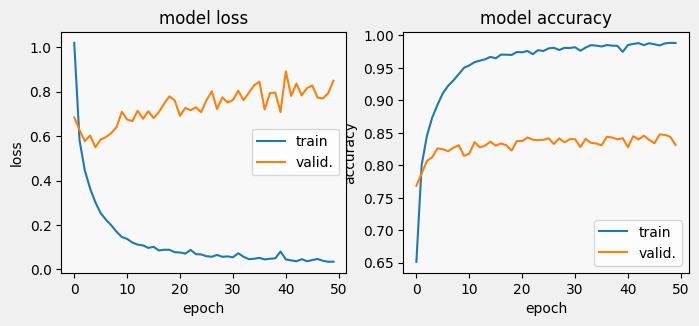

In [9]:
from matplotlib import pyplot as plt
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(7,3), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 121)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 122)

In [ ]:
# Saving model
#-----------------------------------------------------------
model.save('cif10-90_78.h5')  # use your favourite name

In [ ]:
# Evaluate a savde model
from keras.models import load_model
import time as ti

mod=load_model('specify-it')  # fisierul trebuie "upload" in sectiunea fisiere
mod.summary()
t1=ti.time()
score = mod.evaluate(x_test, y_test, verbose=0)
t2=ti.time()
print('Latency (per input sample):', 1000*(t2-t1)/np.shape(x_test)[0], 'ms')
print('Validation accuracy: ',100*score[1],'%')

Labeled class : 9.0
1/1 [==============================] - 0s 24ms/step
Recognized class  :  9


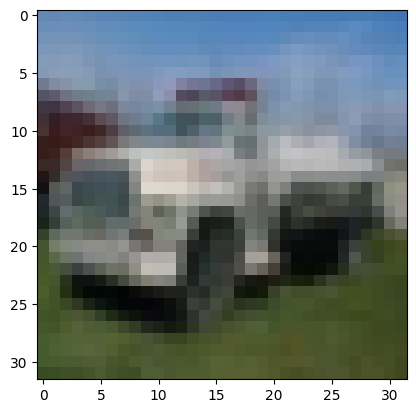

In [17]:
# Examples

selectia=int(np.shape(x_test)[0]*np.random.rand(1))  #

img1=x_test[selectia,:,:,:]
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
if np.shape(x_train)[3]==1:
  plt.imshow(img1[:,:,0],cmap='gray')
elif np.shape(x_train)[3]==3:
  plt.imshow(img1)

label=np.dot(y_test[selectia,:],1+np.array(range(num_classes)).T)
print('Labeled class :', label-1)
z=model.predict(x_test[selectia:selectia+1,:,:,:])
print('Recognized class  : ',np.argmax(z))



In [10]:
# Confusion matrix and more specific performance indicators
#----------------------------------------------------------------

labels=(np.dot(y_test,np.array(range(num_classes)).T)).astype('int16')
pred= model.predict(x_test)
predicted_class_indices=np.argmax(pred,axis=1)
from sklearn.metrics import classification_report, confusion_matrix
C=confusion_matrix(predicted_class_indices,labels)
print (C)
print('Classification Report')
print(classification_report(labels,predicted_class_indices ))


313/313 [==============================] - 4s 8ms/step
[[884  15  42  13   8   7   4   7  35  16]
 [  9 894   1   6   2   1   2   1  13  42]
 [ 12   1 768  37  37  29  13   6   7   1]
 [ 10   6  37 712  27 136  24  35  11   7]
 [ 10   2  52  53 857  29  17  35   4   4]
 [  3   1  13  90  13 740  10  17   3   2]
 [  3   4  58  52  25  23 925   4   5   1]
 [  9   3  19  21  24  33   3 887   2   7]
 [ 33  19   6   3   2   1   0   4 898  10]
 [ 27  55   4  13   5   1   2   4  22 910]]
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1000
           1       0.92      0.89      0.91      1000
           2       0.84      0.77      0.80      1000
           3       0.71      0.71      0.71      1000
           4       0.81      0.86      0.83      1000
           5       0.83      0.74      0.78      1000
           6       0.84      0.93      0.88      1000
           7       0.88      0.89      0.88      1000
     